# EDA for Units Conversions

1. Generate the data
2. Establish the most used unit of measure for each ingredient
3. Estimate the probability of conversion for a given ingredient
4. Demonstrate method for conversion


## Setup Steps

In [2]:
%sh
pip install pint

  Running setup.py bdist_wheel for pint: started
  Running setup.py bdist_wheel for pint: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/c4/51/5e/1645f2de6cd09ff62e27db29123a4a81add45347b355e19ded
Successfully built pint


In [2]:
import datalab.bigquery as bq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datalab.storage as storage
from StringIO import StringIO
from collections import Counter
from pint import UnitRegistry

## Generate Data

Examine at the kadaif dataflow entities data

In [24]:
%bigquery schema --table wellio-kadaif:ingredients.ingredient_entities_2017_01_30_23_01_16_427693

Examine only unit of measure and ingredients that scoring algorithms were mostly certain of (i.e. threshold larger than 90%)

In [6]:
%%sql --module uom_data
SELECT url ,line, ingredient_entity, ingredient_entity_score, uom, uom_score, amount, amount_score
FROM [wellio-kadaif:ingredients.ingredient_entities_2017_01_30_23_01_16_427693]
WHERE uom_score > 0.9 and ingredient_entity_score > 0.9

In [7]:
%%bigquery execute -q uom_data

url,line,ingredient_entity,ingredient_entity_score,uom,uom_score,amount,amount_score
http://www.epicurious.com/recipes/member/views/napa-salad-50067358,! 2 Tbs. soy sauce,soy sauce,0.98400002718,tablespoons,0.999122083187,2.0,0.999984264374
http://www.epicurious.com/recipes/member/views/napa-salad-50067358,! 2 Tbs. soy sauce,soy sauce,0.98400002718,tablespoons,0.999122083187,2.0,0.999984264374
http://www.epicurious.com/recipes/member/views/creme-brulee-french-toast-53031761,! C brown sugar packed,brown sugar,0.959999978542,cups,0.998897433281,1.0,0.999939441681
http://www.epicurious.com/recipes/member/views/creme-brulee-french-toast-53031761,! C brown sugar packed,brown sugar,0.959999978542,cups,0.998897433281,1.0,0.999939441681
http://www.epicurious.com/recipes/member/views/sweet-squash-soup-50106597,! Cup Brown Sugar,brown sugar,1.0,cups,0.999465048313,1.0,0.999974012375
http://www.epicurious.com/recipes/member/views/sweet-squash-soup-50106597,! Cup Brown Sugar,brown sugar,1.0,cups,0.999465048313,1.0,0.999974012375
http://www.epicurious.com/recipes/member/views/hot-sweet-sour-fish-50050605,! Tbs. cornstarch,cornstarch,0.963999986649,tablespoons,0.998011052608,1.0,0.999927043915
http://www.epicurious.com/recipes/member/views/creme-brulee-french-toast-53031761,! Tsp. Vanilla,vanilla,1.0,teaspoons,0.993959069252,1.0,0.99992454052
http://www.epicurious.com/recipes/member/views/creme-brulee-french-toast-53031761,! Tsp. Vanilla,vanilla,1.0,teaspoons,0.993959069252,1.0,0.99992454052
http://www.epicurious.com/recipes/member/views/picante-50037132,! clove garlic smashed,garlic,1.0,cloves,0.991687238216,1.0,0.999795615673


In [8]:
# Create a query using the SQL module defined above and read it into GCS for quick write-read
bq.Query(uom_data).extract("gs://kadaif.getwellio.com/tmp/uom_data_annotations.csv")

Job wellio-kadaif/job_frzH1CAdenB6sJthrnyUpon4Idw completed

In [3]:
# read back into memory 
uom_csv = storage.Item('kadaif.getwellio.com', 'tmp/uom_data_annotations.csv').read_from()
uom_df = pd.read_csv(StringIO(uom_csv))
print list(uom_df)
print uom_df.shape

['url', 'line', 'ingredient_entity', 'ingredient_entity_score', 'uom', 'uom_score', 'amount', 'amount_score']
(3491725, 8)


## Examine unit of measures

In [7]:
%sh
gsutil cp gs://kadaif.getwellio.com/tmp/unit_def.txt unit_def.txt

Copying gs://kadaif.getwellio.com/tmp/unit_def.txt...
/ [1 files][  145.0 B/  145.0 B]                                                
Operation completed over 1 objects/145.0 B.                                      


In [4]:
# look at all units of measures alternatives
uom_list = uom_df['uom'].unique()
uom_list
print uom_list
print len(uom_list)

['tablespoons' 'cups' 'teaspoons' 'cloves' 'units' 'cans' 'ounces' 'jars'
 'pints' 'sticks' 'sprigs' 'inches' 'pounds' 'gallons' 'bunches' 'heads'
 'stalks' 'slices' 'pinches' 'milliliters' 'leaves' 'glasses' 'grams'
 'liters' 'kilograms' 'dashes' 'sheets' 'ribs' 'packages' 'quarts'
 'fluid ounces' 'drops' 'cubes' 'scoops' 'boxes' 'handfuls' 'bags'
 'bottles' 'loaves' 'packets' 'strips' 'fillets']
42


In [5]:
# We will define standard unit of measures and conversion using the Pint library 
# however in that library there seems to be a few units that are not used in the common manner 
# (e.g. pinches is a measure of length in the library) and so we overwrite it
ureg = UnitRegistry()
ureg.load_definitions('unit_def.txt') 


In [20]:
print ureg.get_compatible_units('cups')
print ureg.get_compatible_units('ounces')

frozenset([<Unit('stere')>, <Unit('liter')>])
frozenset([<Unit('atomic_mass_unit')>, <Unit('metric_ton')>, <Unit('bag')>, <Unit('electron_mass')>, <Unit('gram')>])


In [6]:
# Examine which units can we not convert from the list we have
non_standard_uom_list = []

for uom in uom_list:
  try:
    ureg.parse_expression(uom)
  except:
    non_standard_uom_list.append(uom)

print non_standard_uom_list
print float(len(non_standard_uom_list))/len(uom_list)

['units', 'cans', 'jars', 'sticks', 'sprigs', 'bunches', 'heads', 'stalks', 'slices', 'leaves', 'glasses', 'sheets', 'ribs', 'packages', 'fluid ounces', 'cubes', 'scoops', 'boxes', 'handfuls', 'bottles', 'loaves', 'packets', 'strips', 'fillets']
0.571428571429


## Examine conversion frequencies for ingredients

In [7]:
# estimate the frequency of an ingredient appearing in a recipe 
# (if an ingredient appears twice in a recipe it will only be counted once here)
ingredient_frequency = uom_df.groupby(['ingredient_entity']).url.nunique()
total_num_recipe = uom_df.url.nunique()
res = ingredient_frequency.divide(total_num_recipe)
ingredient_frequency_dict = dict(zip(res.index, res.values))

In [8]:
# look at the frequencies of the different units 
ingredient_uom_cross_tab = pd.crosstab(uom_df.ingredient_entity, uom_df.uom, normalize='index')
ingredient_uom_cross_tab.head(20)

# find the mode UOM for each ingredient , the Mode UOM will be used as the standard 
# unit of measure
# for a given ingredient
most_common_UOM = ingredient_uom_cross_tab.idxmax(axis=1)
most_common_UOM = most_common_UOM.to_dict()

In [9]:
# define a function that allows to check if two units are comparable
def uom_compatible(target_unit, standard_unit):  
  try:
    target_unit_comparable = ureg.get_compatible_units(target_unit)
    unit_comparable = ureg.get_compatible_units(standard_unit)

    if unit_comparable == target_unit_comparable:
      return True
    else:
      return False
  except:
    return False

In [ ]:
# for a given ingredient, estimate the probability that a recipe is "convertible" 
ingredient_conversion_dict = {}

for index, row in uom_df.iterrows():
    ingredient = row['ingredient_entity']
    uom = row['uom']
    url = row['url']
    standard_mode_uom = most_common_UOM[ingredient]
    if uom != standard_mode_uom:
      comparable = uom_compatible(uom,standard_mode_uom)
      if not comparable:
        if ingredient in ingredient_conversion_dict:
          ingredient_conversion_dict[ingredient].add(url) 
        else:
          ingredient_conversion_dict[ingredient] = {url}

print len(ingredient_conversion_dict['sugar'])
print most_common_UOM['sugar']
    


In [44]:
# estimtate the frequency of an ingredient across recipe and the freq it would need to be converted
ingredient_conversion_freq = {}

for ingredient, list_url in ingredient_conversion_dict.iteritems():
  num_recipes = ingredient_frequency[ingredient]
  num_convertable_recipe =  len(list_url)
  ingredient_conversion_freq[ingredient] = [num_convertable_recipe,num_recipes,num_recipes/float(total_num_recipe),
                                          num_convertable_recipe/float(num_recipes),num_convertable_recipe/float(total_num_recipe) ]

  
ingredient_conversion_freq['sugar']


[1780, 93579, 0.18436705157328362, 0.019021361630280297, 0.0035069123606839663]

In [48]:
ingredient_freq_matrix = pd.DataFrame.from_dict(ingredient_conversion_freq).T
ingredient_freq_matrix.columns = ['non_convertable_recipes','total_num_recipes','ingredient_freq','cond_non_conversion_freq','non_conversion_freq']
ingredient_freq_matrix.sort_values(by="non_conversion_freq",ascending=0)

,non_convertable_recipes,total_num_recipes,ingredient_freq,cond_non_conversion_freq,non_conversion_freq
onion,62047.0,62047.0,0.122243,1.000000,0.122243
eggs,22141.0,22141.0,0.043622,1.000000,0.043622
tomatoes,18817.0,18817.0,0.037073,1.000000,0.037073
onions,15005.0,15005.0,0.029562,1.000000,0.029562
carrots,14058.0,14058.0,0.027697,1.000000,0.027697
garlic,13083.0,37956.0,0.074780,0.344689,0.025776
chicken breasts,11506.0,11506.0,0.022669,1.000000,0.022669
bacon,10419.0,10419.0,0.020527,1.000000,0.020527
red onion,9902.0,9902.0,0.019509,1.000000,0.019509
butter,9545.0,109892.0,0.216507,0.086858,0.018805


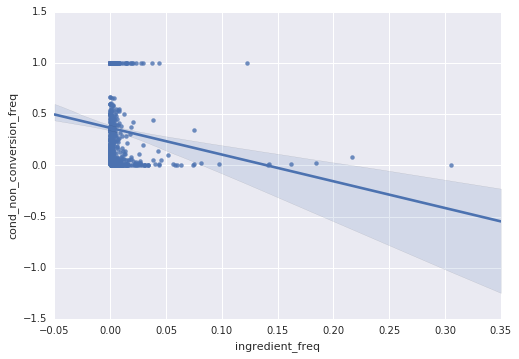

In [50]:
sns.regplot(x="ingredient_freq", y="cond_non_conversion_freq", data=ingredient_freq_matrix)

Lets parse the ingredient line on "about" string and see if we can figure out some of the conversion issues with 'Sugar'

In [ ]:
import re
from scipy import polyfit

  
# find all the lines that have the word about
ingredient_lines = uom_df[uom_df['ingredient_entity'] == 'sugar']['line']
units_alternatives = [string.split('about') for string in ingredient_lines if 'about' in string]

# filter the items that don't have two numbers
sugar_df = [['1 cup','180 grams'],['12 cups','5.5 lbs'],['5 ounces','0.75 cup'],['8 ounces','1 cup'],['1 cup','7 ounces']]
sugar_df


sugar_dict = {'pounds':np.array([0.396832,5.5,0.3125,0.5,0.4375]) , 'cups':np.array([1,12,0.75,1,1])}
print sugar_dict
(ar,br)=polyfit(sugar_dict['pounds'],sugar_dict['cups'],1)
print (ar,br)

sns.regplot(x=sugar_dict['pounds'], y=sugar_dict['cups'], robust=True)

{'cups': array([  1.  ,  12.  ,   0.75,   1.  ,   1.  ]), 'pounds': array([ 0.396832,  5.5     ,  0.3125  ,  0.5     ,  0.4375  ])}
(2.1733624154008782, 0.043468788403142097)
